In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import fish_models
import robofish.io

In [3]:
fishes = 12
clusters = 4
cluster_step = 1

MeanShift clustering aims to discover blobs in a smooth density of samples. It is a centroid based algorithm, which works by updating candidates for centroids to be the mean of the points within a given region. These candidates are then filtered in a post-processing stage to eliminate near-duplicates to form the final set of centroids.

The algorithm automatically sets the number of clusters, instead of relying on a parameter bandwidth, which dictates the size of the region to search through. This parameter can be set manually, but can be estimated using the provided estimate_bandwidth function, which is called if the bandwidth is not set.

The algorithm is not highly scalable, as it requires multiple nearest neighbor searches during the execution of the algorithm. The algorithm is guaranteed to converge, however the algorithm will stop iterating when the change in centroids is small.

Labelling a new sample is performed by finding the nearest centroid for a given sample.

In [4]:
from sklearn.cluster import MeanShift
import sklearn.cluster as cl
import sklearn.metrics as mt

class MeanShiftFishModel(fish_models.gym_interface.AbstractRaycastBasedModel):
    def choose_action(self, view: np.ndarray):
        # Return speed and turn from view
        param = np.random.randint(5, 51)
        speed = np.random.random() * param
        
        # step 1: try to find a neigbour to make a friendship
        X = view[0:4]
        turn = self.find_neigbour_fish(X)
        
        # step 2: avoid walls
        # if walls is to close - avoid wall first 
        if view[6] > 0.9:
            turn = 5 * np.pi
        
        return speed, turn
    
    def find_neigbour_fish(self, X):
        # go straight by default
        turn = 0
        
        # сluster the data of neighbor fishes
        cluster = self.findClusters_meanShift(X)
        
        # Coordinates of cluster centers.
        centroids = cluster.cluster_centers_
        
        # the distance to fish bins is between 0 and 1, where 0 means far away and 1 means close
        # find the nearest fish from centroids, it should be the fish with the maximum value (closest)
        nearest = max(centroids)
        
        # find the nearest valus in original array that should belong to the centroid
        _, bin_idx = self.find_nearest(X, nearest)

        if bin_idx == 0:
            turn = - np.pi / 6
        elif bin_idx == 1: 
            param = np.random.randint(6, 13)
            turn = - np.pi/ param
        elif bin_idx == 2: 
            param = np.random.randint(1, 4)
            turn =  param * np.pi
        elif bin_idx == 3: 
            param = np.random.randint(4, 9)
            turn =  param * np.pi
        
        return turn
    
    def findClusters_meanShift(self, X):

        # create the classifier object
        meanShift = cl.MeanShift(bandwidth=2, bin_seeding=True)

        # fit the data
        X = X.reshape(-1, 1)
        return meanShift.fit(X)

    def euclidean_distance(x_1, x_2):
        return np.sum((x_1-x_2)**2, axis = 1)
    
    def find_nearest(self, array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return array[idx], idx
    
model = MeanShiftFishModel()

In [5]:
raycast = fish_models.gym_interface.Raycast(
            n_wall_raycasts=5,
            n_fish_bins=4,
            fov_angle_fish_bins=np.pi,
            fov_angle_wall_raycasts=np.pi,
            world_bounds=([-50, -50], [50, 50]),
        )



In [6]:
data_folder = Path("data/live_female_female/train")

dset = fish_models.datasets.io_dataset.IoDataset(
    data_folder,
    raycast,
    output_strings=["poses", "actions", "views"],
    reduce_dim=2,
    max_files=10,
)

  0%|          | 0/10 [00:00<?, ?it/s]

Loading data from 10 files.


  0%|          | 0/10 [00:00<?, ?it/s]

Calculating views from 10 files.


100%|██████████| 10/10 [00:29<00:00,  3.00s/it]

Created IoDataset:
Reduced the first 3 dimensions from (10, 2, 8989) to (179780)
poses	(179780, 3):	consisting of x, y, calc_ori_rad.
actions	(179760, 2):	consisting of speed[cm/s] and turn [rad/s].
views	(179760, 9):	4 fish_bins and 5 wall ray casts.



In [7]:
data_folder_test = Path("data/live_female_female/test")

dset_test = fish_models.datasets.io_dataset.IoDataset(
    data_folder,
    raycast,
    output_strings=["poses", "actions", "views"],
    reduce_dim=2,
    max_files=5,
)

  0%|          | 0/5 [00:00<?, ?it/s]

Loading data from 5 files.


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating views from 5 files.


100%|██████████| 5/5 [00:11<00:00,  2.33s/it]

Created IoDataset:
Reduced the first 3 dimensions from (5, 2, 8989) to (89890)
poses	(89890, 3):	consisting of x, y, calc_ori_rad.
actions	(89880, 2):	consisting of speed[cm/s] and turn [rad/s].
views	(89880, 9):	4 fish_bins and 5 wall ray casts.



In [8]:
generator = fish_models.gym_interface.TrackGeneratorGymRaycast(
    model, raycast, [100,100], 25
)

track = generator.create_track(n_guppies=fishes, trackset_len=1000)
print(track.shape)

100%|██████████| 999/999 [00:40<00:00, 24.53it/s]

(12, 1000, 3)


In [9]:
f = generator.as_io_file(track)
f.save_as("output/mean_shift.hdf5")

<HDF5 file "8b8891cd-efbf-406f-9c81-a1ffcae94685" (mode r+)>

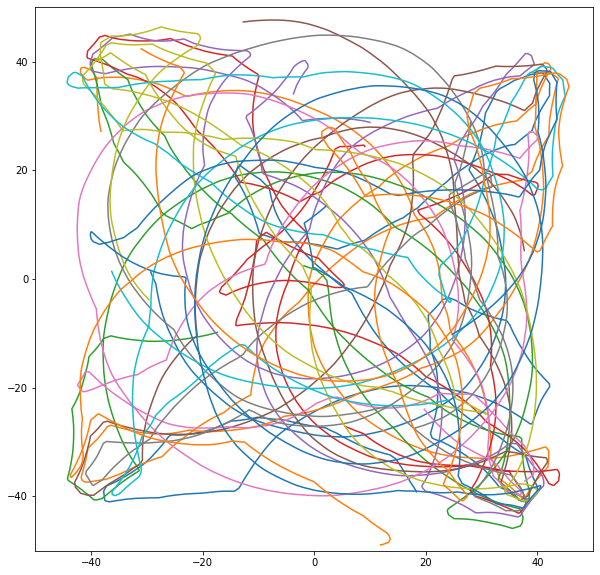

In [10]:
plt.figure(figsize=(10,10))
plt.xlim(-50,50)
plt.ylim(-50,50)
for fish_id in range(fishes):
    plt.plot(track[fish_id, :, 0], track[fish_id, :, 1])
plt.show()

In [11]:
def calculate_speed_from_position(track):
    speed = []
    
    for i in range(track.shape[1] - 1):
        s = ((track[0, i + 1, 0] - track[0, i, 0])**2 + (track[0, i + 1, 1] - track[0, i, 1])**2)**0.5
        speed.append(s)
    
    return np.array(speed)


In [12]:
speed = calculate_speed_from_position(track)
print(speed.shape)
print(speed.ndim)

bins = np.arange(start=0, stop=2, step=0.01)


(999,)
1


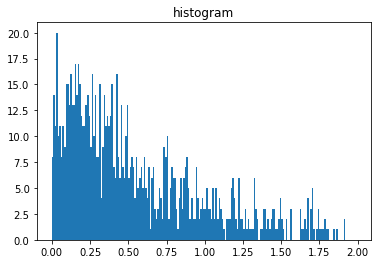

In [13]:
plt.hist(speed, bins) 
plt.title("histogram") 
plt.show()